# Поиск частых наборов


## Задание


1. Выполните поиск частых наборов объектов в наборе данных с помощью следующих алгоритмов (или их модификаций): Apriori, FP‑Growth, ECLAT. Варьируйте пороговое значение поддержки (например: 1%, 3%, 5%, 10%, 15%, 20%). Проверьте идентичность результатов, полученных с помощью различных алгоритмов.
2. Подготовьте список частых наборов, в которых не более семи объектов (разумное количество). Проанализируйте и изложите содержательный смысл полученного результата.
3. Выполните визуализацию полученных результатов в виде следующих диаграмм:
  - сравнение быстродействия алгоритмов на фиксированном наборе данных при изменяемом пороге поддержки;
  - общее количество частых наборов объектов на фиксированном наборе данных при изменяемом пороге поддержки;
  - максимальная длина частого набора объектов на фиксированном наборе данных при изменяемом пороге поддержки;
  - количество частых наборов объектов различной длины на фиксированном наборе данных при изменяемом пороге поддержки.
4. Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  
  - формулировка задания;
  - гиперссылка на каталог репозитория с исходными текстами, набором данных и др. сопутствующими материалами;
  - рисунки с результатами визуализации;
  - пояснения, раскрывающие смысл полученных результатов.

## Импорт библиотек

In [ ]:
! pip install pyECLAT

In [ ]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import time
from collections import defaultdict
import matplotlib.pyplot as plt
#from pyECLAT import ECLAT

## Постановка задачи и загрузка набора данных
Набор данных импортирован с kaggle.com: [Books dataset](https://www.kaggle.com/datasets/sarveshjoshi10/books-dataset/code).

Набор содержит 271 000 записей о книах: название, автор, год публикации, издательство, приложения в виде ссылок на изображения по каждой книге.

Столбцы данных:
- ISBN: номер книги ISBN.
- Название книги: Название книги.
- Автор книги: Автор (ы) книги.
- Год публикации: год, когда книга была опубликована.
- Издатель: издательство или организация, ответственная за публикацию книги.

Задача: найти частые наборы издательств, в которых публикуются авторы.

### Подготовка данных

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sarveshjoshi10/books-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sarveshjoshi10/books-dataset/versions/2


In [ ]:
# Чтение набора данных с указанием кодировки
df = pd.read_csv('/root/.cache/kagglehub/datasets/sarveshjoshi10/books-dataset/versions/2/BX-Books.csv', encoding='windows-1252')
df.head()

<ipython-input-26-1ba81502a3fb>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/root/.cache/kagglehub/datasets/sarveshjoshi10/books-dataset/versions/2/BX-Books.csv', encoding='windows-1252')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [ ]:
df = df.dropna(subset=['Book-Author', 'Publisher']).drop_duplicates()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271356 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271356 non-null  object
 1   Book-Title           271356 non-null  object
 2   Book-Author          271356 non-null  object
 3   Year-Of-Publication  271356 non-null  object
 4   Publisher            271356 non-null  object
 5   Image-URL-S          271356 non-null  object
 6   Image-URL-M          271356 non-null  object
 7   Image-URL-L          271353 non-null  object
dtypes: object(8)
memory usage: 18.6+ MB


In [ ]:
# 1. Получить список всех уникальных авторов
unique_authors = df['Book-Author'].unique()
unique_authors, len(unique_authors)

(array(['Mark P. O. Morford', 'Richard Bruce Wright', "Carlo D'Este", ...,
        'David Biggs', 'Teri Sloat', 'Christopher  Biffle'], dtype=object),
 102021)

In [ ]:
# 2. Получить список всех уникальных издательств
unique_publishers = df['Publisher'].unique()
unique_publishers, len(unique_publishers)

(array(['Oxford University Press', 'HarperFlamingo Canada',
        'HarperPerennial', ..., 'Tempo', 'Life Works Books', 'Connaught'],
       dtype=object),
 16806)

In [ ]:
author_ids = {author: idx for idx, author in enumerate(df['Book-Author'].unique())}
authors_df = pd.DataFrame(list(author_ids.items()), columns=['Book-Author', 'Author_ID'])

print("Таблица авторов:")
authors_df.head()

Таблица авторов:


,Book-Author,Author_ID
0,Mark P. O. Morford,0
1,Richard Bruce Wright,1
2,Carlo D'Este,2
3,Gina Bari Kolata,3
4,E. J. W. Barber,4


In [ ]:
authors_df.to_csv('Authors.csv', index=False)

In [ ]:
# Создание таблицы идентификаторов издательств и издательств
publisher_ids = {publisher: idx for idx, publisher in enumerate(df['Publisher'].unique())}
publishers_df = pd.DataFrame(list(publisher_ids.items()), columns=['Publisher', 'Publisher_ID'])

In [ ]:
publishers_df.to_csv('publishers.csv', index=False)

In [ ]:
publishers_df

,Publisher,Publisher_ID
0,Oxford University Press,0
1,HarperFlamingo Canada,1
2,HarperPerennial,2
3,Farrar Straus Giroux,3
4,W. W. Norton &amp; Company,4
...,...,...
16801,Dodd Mead &amp; Company,16801
16802,Audio Craft Pr Inc,16802
16803,Tempo,16803
16804,Life Works Books,16804


In [ ]:
# Присвоение идентификаторов авторам и издательствам в исходном наборе данных
df['Author_ID'] = df['Book-Author'].map(author_ids)
df['Publisher_ID'] = df['Publisher'].map(publisher_ids)

# Создание таблицы: TID (айди автора) и Items (айди издательств)
tid_items = df.groupby('Author_ID')['Publisher_ID'].apply(lambda x: list(set(x))).reset_index()
tid_items.columns = ['TID', 'Items']

tid_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102021 entries, 0 to 102020
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   TID     102021 non-null  int64 
 1   Items   102021 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


In [ ]:
# Фильтрация строк, где в Items содержится два или более элемента
tid_items = tid_items[tid_items['Items'].apply(lambda x: len(x) >= 2)]
tid_items.head()

,TID,Items
0,0,"[0, 576]"
1,1,"[1, 3670]"
2,2,"[33, 2, 281]"
3,3,"[321, 3]"
5,5,"[256, 5, 6, 136, 139, 25, 27, 30, 542, 418, 15..."


In [ ]:
tid_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27010 entries, 0 to 101972
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TID     27010 non-null  int64 
 1   Items   27010 non-null  object
dtypes: int64(1), object(1)
memory usage: 633.0+ KB


In [ ]:
tid_items.to_csv('tid_items.csv', index=False)

In [ ]:
def get_books_by_author(df, author_name):
    return df[df['Book-Author'] == author_name][['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

In [ ]:
author_name = "tk"
author_books = get_books_by_author(df, author_name)
author_books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
108819,0786834617,"Annette Mysteries, The - Box Set of 4 (Walt Di...",tk,2003,Disney Press
123695,0786845848,The Lizzie McGuire Movie: Jr. Novel,tk,2003,Disney Press
197735,0786818026,Ella Enchanted Scrapbook : Movie Tie-In,tk,2004,Miramax Kids
203968,0786817631,Spy Kids 3 Scrapbook,tk,2003,Miramax Kids
243506,0786853131,Walt Disney's Santa's Toy Shop : Walt Disney C...,tk,2000,Disney Editions
270548,0786832533,Disney's Classic Mickey (Eye Novels),tk,1999,Disney Editions


Будем работать с tid_items, содержащем поля ['TID', 'Items']. Где TID - автор, Items - список издательств, в которых он публикуется.

## 1. Поиск частых наборов
Apriori, FP‑Growth, ECLAT.

Пороговое значение поддержки (например: 1%, 3%, 5%, 10%, 15%, 20%).


In [ ]:
support_thresholds = [0.0015, 0.002, 0.0025, 0.005, 0.01, 0.03, 0.1, 0.5]

### Поиск частых наборов алгоритмом Apriori

Начинается с поиска всех частых элементов, которые соответствуют минимальному порогу поддержки (support): генерация набора кандидатов (C1).

Генерация кандидатов: на каждом шаге алгоритм создает новые наборы кандидатов, объединяя частые наборы элементов из предыдущего шага. Для каждого кандидата в наборе проводится подсчет количества транзакций, в которых он встречается.

Кандидаты, у которых поддержка (support) превышает минимальный порог, считаются частыми наборами. Эти частые наборы сохраняются для следующего шага.

Повторение шагов. Шаги 2-4 повторяются, пока не будут обнаружены все частые наборы элементов. На каждом следующем шаге алгоритм создает наборы кандидатов с нарастающей длиной (k+1), объединяя частые наборы длины k через префиксы.

Алгоритм завершается, когда на очередном шаге не удается найти новых частых наборов.

In [ ]:
# Метод для выполнения алгоритма Apriori и дозаписи результатов в DataFrame
def run_apriori_and_save_results(df, support_thresholds, results_df, result_time_df):
    # Преобразование данных в формат для алгоритма Apriori
    transaction_list = df['Items'].tolist()
    te = TransactionEncoder()
    te_ary = te.fit(transaction_list).transform(transaction_list)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # Выполнение алгоритма Apriori и дозапись результатов
    for support in support_thresholds:
        start_time = time.time()
        frequent_itemsets = apriori(df_encoded, min_support=support, use_colnames=True)
        end_time = time.time()

        frequent_itemsets['Support'] = support
        frequent_itemsets['Algorithm'] = 'apriori'
        results_df = pd.concat([results_df, frequent_itemsets], ignore_index=True)

        # Сохранение времени выполнения
        elapsed_time = end_time - start_time
        result_time_df = pd.concat([result_time_df, pd.DataFrame({'Support': [support], 'Time': [elapsed_time], 'Algorithm': ['apriori']})], ignore_index=True)

    return results_df, result_time_df

In [ ]:
results_df = pd.DataFrame(columns=['Support', 'itemsets', 'support', 'Algorithm'])
result_time_df = pd.DataFrame(columns=['Support', 'Time', 'Algorithm'])

results_df, result_time_df = run_apriori_and_save_results(tid_items, support_thresholds, results_df, result_time_df)

# Сохранение результатов в файлы CSV
results_df.to_csv('apriori_results.csv', index=False)
result_time_df.to_csv('apriori_times.csv', index=False)

print("Результаты алгоритма Apriori:")
print(results_df.head())

print("Время выполнения алгоритма Apriori:")
print(result_time_df.head())

<ipython-input-44-cb3f66cea60a>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, frequent_itemsets], ignore_index=True)
<ipython-input-44-cb3f66cea60a>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_time_df = pd.concat([result_time_df, pd.DataFrame({'Support': [support], 'Time': [elapsed_time], 'Algorithm': ['apriori']})], ignore_index=True)


Результаты алгоритма Apriori:
   Support itemsets   support Algorithm
0   0.0015      (0)  0.015291   apriori
1   0.0015      (3)  0.005220   apriori
2   0.0015      (4)  0.012477   apriori
3   0.0015      (5)  0.014624   apriori
4   0.0015      (6)  0.029545   apriori
Время выполнения алгоритма Apriori:
   Support        Time Algorithm
0   0.0015  146.833424   apriori
1   0.0020   86.267111   apriori
2   0.0025   43.464696   apriori
3   0.0050   10.456662   apriori
4   0.0100    2.083667   apriori


### Поиск частых наборов алгоритмов FP‑Growth

FP-Growth

FP-Growth сначала проходит через данные один раз, чтобы подсчитать частоту каждого элемента, а затем проходит второй раз, чтобы построить FP-дерево. В этом дереве каждый путь представляет набор транзакций, а узлы представляют элементы и их поддержку.

В отличие от алгоритма Apriori, который генерирует кандидаты на каждом шаге, FP-Growth рекурсивно разбивает FP-дерево на условные поддеревья для поиска часто встречающихся паттернов.

In [ ]:
# Метод для выполнения алгоритма FP-Growth и дозаписи результатов в DataFrame
def run_fpgrowth_and_save_results(df, support_thresholds, results_df, result_time_df):
    # Преобразование данных в формат для алгоритма FP-Growth
    transaction_list = df['Items'].tolist()
    te = TransactionEncoder()
    te_ary = te.fit(transaction_list).transform(transaction_list)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # Выполнение алгоритма FP-Growth и дозапись результатов
    for support in support_thresholds:
        start_time = time.time()
        frequent_itemsets = fpgrowth(df_encoded, min_support=support, use_colnames=True)
        end_time = time.time()

        frequent_itemsets['Support'] = support
        frequent_itemsets['Algorithm'] = 'fpgrowth'
        results_df = pd.concat([results_df, frequent_itemsets], ignore_index=True)

        # Сохранение времени выполнения
        elapsed_time = end_time - start_time
        result_time_df = pd.concat([result_time_df, pd.DataFrame({'Support': [support], 'Time': [elapsed_time], 'Algorithm': ['fpgrowth']})], ignore_index=True)

    return results_df, result_time_df

In [ ]:
results_df = pd.DataFrame(columns=['Support', 'itemsets', 'support', 'Algorithm'])
result_time_df = pd.DataFrame(columns=['Support', 'Time', 'Algorithm'])

results_df, result_time_df = run_fpgrowth_and_save_results(tid_items, support_thresholds, results_df, result_time_df)

# Сохранение результатов в файлы CSV
results_df.to_csv('fpgrowth_results.csv', index=False)
result_time_df.to_csv('fpgrowth_times.csv', index=False)

print("Результаты алгоритма FP-Growth:")
print(results_df.head())

print("Время выполнения алгоритма FP-Growth:")
print(result_time_df.head())

<ipython-input-46-1752ba8b37f8>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, frequent_itemsets], ignore_index=True)
<ipython-input-46-1752ba8b37f8>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_time_df = pd.concat([result_time_df, pd.DataFrame({'Support': [support], 'Time': [elapsed_time], 'Algorithm': ['fpgrowth']})], ignore_index=True)


Результаты алгоритма FP-Growth:
   Support itemsets   support Algorithm
0   0.0015      (0)  0.015291  fpgrowth
1   0.0015    (576)  0.004258  fpgrowth
2   0.0015     (33)  0.048093  fpgrowth
3   0.0015    (281)  0.007071  fpgrowth
4   0.0015    (321)  0.010515  fpgrowth
Время выполнения алгоритма FP-Growth:
   Support       Time Algorithm
0   0.0015  55.869616  fpgrowth
1   0.0020  32.084808  fpgrowth
2   0.0025  22.280427  fpgrowth
3   0.0050  12.855608  fpgrowth
4   0.0100   9.870246  fpgrowth


### Поиск частых наборов алгоритмом ECLAT

В отличие от других алгоритмов, ECLAT работает с вертикальным представлением данных и использует пересечение TID наборов для вычисления поддержки.

Поддержка каждого набора-кандидата вычисляется как пересечение наборов TID для правильно выбранных подмножеств.

1. Данные преобразуются в вертикальный формат: каждому элементу присваивается множество TID, в которых элемент присутствует.
2. Рекурсивный поиск частых наборов элементов: для каждого частого набора элементов пересекаются TID для вычисления поддержки.
3. Поиск в глубину по префиксному дереву: обрабатываются наборы элементов с общим префиксом.

In [ ]:
# Метод для выполнения алгоритма ECLAT и дозаписи результатов в DataFrame
def run_eclat_and_save_results(df, support_thresholds, results_df, result_time_df):
    # Преобразование данных в формат для алгоритма ECLAT
    transaction_list = df['Items'].tolist()
    te = TransactionEncoder()
    te_ary = te.fit(transaction_list).transform(transaction_list)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # Преобразование данных в вертикальный формат
    vertical_data = defaultdict(set)
    for tid, transaction in enumerate(transaction_list):
        for item in transaction:
            vertical_data[item].add(tid)

    # Функция для выполнения рекурсивного ECLAT
    def eclat(prefix, items, min_support_count):
        while items:
            i = items.pop()
            isets = prefix + [i]
            tids = vertical_data[i]

            # Пересечение наборов TID для вычисления поддержки
            support = len(tids)

            if support >= min_support_count:
                yield isets, support
                suffix = {item for item in items if len(tids & vertical_data[item]) >= min_support_count}
                for iset, sup in eclat(isets, suffix, min_support_count):
                    yield iset, sup

    # Выполнение алгоритма ECLAT и дозапись результатов
    for support in support_thresholds:
        start_time = time.time()
        min_support_count = support * len(transaction_list)
        frequent_itemsets = []

        items = set(vertical_data.keys())
        for itemset, sup in eclat([], items, min_support_count):
            frequent_itemsets.append((itemset, sup / len(transaction_list)))

        end_time = time.time()

        # Преобразование частых наборов в DataFrame
        frequent_itemsets_df = pd.DataFrame(frequent_itemsets, columns=['itemsets', 'support'])
        frequent_itemsets_df['Support'] = support
        frequent_itemsets_df['Algorithm'] = 'eclat'
        results_df = pd.concat([results_df, frequent_itemsets_df], ignore_index=True)

        # Сохранение времени выполнения
        elapsed_time = end_time - start_time
        result_time_df = pd.concat([result_time_df, pd.DataFrame({'Support': [support], 'Time': [elapsed_time], 'Algorithm': ['eclat']})], ignore_index=True)

    return results_df, result_time_df


In [ ]:
results_df = pd.DataFrame(columns=['Support', 'itemsets', 'support', 'Algorithm'])
result_time_df = pd.DataFrame(columns=['Support', 'Time', 'Algorithm'])

results_df, result_time_df = run_eclat_and_save_results(tid_items, support_thresholds, results_df, result_time_df)

# Сохранение результатов в файлы CSV
results_df.to_csv('eclat_results.csv', index=False)
result_time_df.to_csv('eclat_times.csv', index=False)

print("Результаты алгоритма eclat:")
print(results_df.head())

print("Время выполнения алгоритма eclat:")
print(result_time_df.head())

<ipython-input-48-38e492bfab74>:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, frequent_itemsets_df], ignore_index=True)
<ipython-input-48-38e492bfab74>:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_time_df = pd.concat([result_time_df, pd.DataFrame({'Support': [support], 'Time': [elapsed_time], 'Algorithm': ['eclat']})], ignore_index=True)
<ipython-input-48-38e492bfab74>:47: FutureWarning: The behavior of DataFrame concatenation with empty or all

Результаты алгоритма eclat:
   Support               itemsets   support Algorithm
0   0.0015                    [0]  0.015291     eclat
1   0.0015                [0, 98]  0.013069     eclat
2   0.0015            [0, 98, 38]  0.043576     eclat
3   0.0015       [0, 98, 38, 104]  0.012292     eclat
4   0.0015  [0, 98, 38, 104, 213]  0.050944     eclat
Время выполнения алгоритма eclat:
   Support      Time Algorithm
0   0.0015  3.065846     eclat
1   0.0020  2.484904     eclat
2   0.0025  2.659859     eclat
3   0.0050  2.355855     eclat
4   0.0100  1.307423     eclat


### Проверка идентичности результатов

In [ ]:
# Загрузка данных из CSV-файлов
apriori_results = pd.read_csv('apriori_results.csv')
fpgrowth_results = pd.read_csv('fpgrowth_results.csv')
eclat_results = pd.read_csv('eclat_results.csv')

common_counts = {'support': [], 'apriori_fpgrowth': [], 'apriori_eclat': [], 'fpgrowth_eclat': [], 'all_algorithms': []}

In [ ]:
# Сравнение частых наборов по пороговым значениям поддержки
for support in support_thresholds:
    # Фильтрация данных по пороговому значению поддержки
    apriori_filtered = apriori_results[apriori_results['Support'] == support]
    fpgrowth_filtered = fpgrowth_results[fpgrowth_results['Support'] == support]
    eclat_filtered = eclat_results[eclat_results['Support'] == support]

    # Преобразование столбца 'itemsets' в формат множества
    apriori_itemsets = set(apriori_filtered['itemsets'].apply(eval).apply(frozenset))
    fpgrowth_itemsets = set(fpgrowth_filtered['itemsets'].apply(eval).apply(frozenset))
    eclat_itemsets = set(eclat_filtered['itemsets'].apply(eval).apply(frozenset))

    # Сравнение частых наборов
    common_apriori_fpgrowth = apriori_itemsets.intersection(fpgrowth_itemsets)
    common_apriori_eclat = apriori_itemsets.intersection(eclat_itemsets)
    common_fpgrowth_eclat = fpgrowth_itemsets.intersection(eclat_itemsets)
    common_all = apriori_itemsets.intersection(fpgrowth_itemsets).intersection(eclat_itemsets)

    # Добавление результатов в списки
    common_counts['support'].append(support)
    common_counts['apriori_fpgrowth'].append(len(common_apriori_fpgrowth))
    common_counts['apriori_eclat'].append(len(common_apriori_eclat))
    common_counts['fpgrowth_eclat'].append(len(common_fpgrowth_eclat))
    common_counts['all_algorithms'].append(len(common_all))

# Преобразование результатов в DataFrame
comparison_df = pd.DataFrame(common_counts)

In [ ]:
comparison_df

,support,apriori_fpgrowth,apriori_eclat,fpgrowth_eclat,all_algorithms
0,0.0015,938,938,938,938
1,0.0020,580,580,580,580
2,0.0025,424,424,424,424
3,0.0050,172,172,172,172
4,0.0100,65,65,65,65
5,0.0300,11,11,11,11
6,0.1000,0,0,0,0
7,0.5000,0,0,0,0


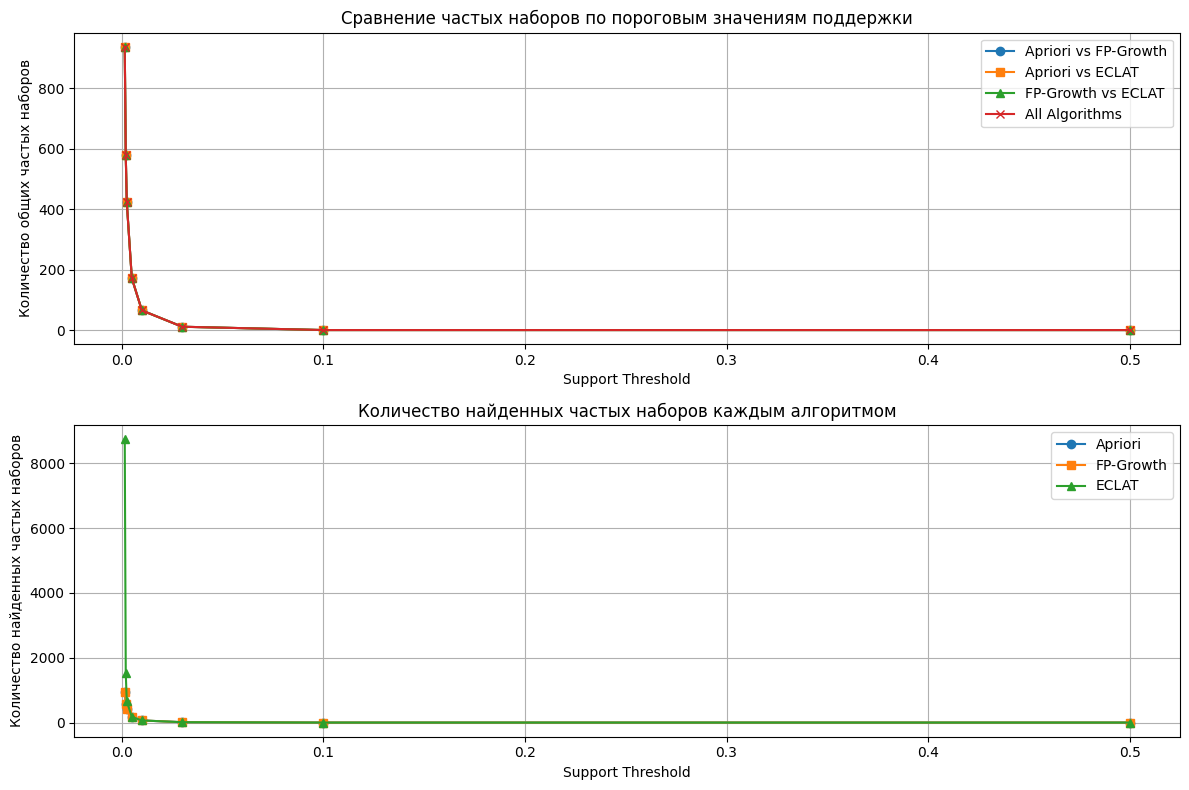

In [ ]:
# Подсчет количества частых наборов, найденных каждым алгоритмом по пороговым значениям поддержки
apriori_counts = []
fpgrowth_counts = []
eclat_counts = []

for support in support_thresholds:
    apriori_filtered = apriori_results[apriori_results['Support'] == support]
    fpgrowth_filtered = fpgrowth_results[fpgrowth_results['Support'] == support]
    eclat_filtered = eclat_results[eclat_results['Support'] == support]

    apriori_counts.append(len(apriori_filtered))
    fpgrowth_counts.append(len(fpgrowth_filtered))
    eclat_counts.append(len(eclat_filtered))

# Построение графиков
plt.figure(figsize=(12, 8))

# График сравнения общих частых наборов
plt.subplot(2, 1, 1)
plt.plot(comparison_df['support'], comparison_df['apriori_fpgrowth'], label='Apriori vs FP-Growth', marker='o')
plt.plot(comparison_df['support'], comparison_df['apriori_eclat'], label='Apriori vs ECLAT', marker='s')
plt.plot(comparison_df['support'], comparison_df['fpgrowth_eclat'], label='FP-Growth vs ECLAT', marker='^')
plt.plot(comparison_df['support'], comparison_df['all_algorithms'], label='All Algorithms', marker='x')
plt.xlabel('Support Threshold')
plt.ylabel('Количество общих частых наборов')
plt.title('Сравнение частых наборов по пороговым значениям поддержки')
plt.legend()
plt.grid(True)

# График количества найденных наборов каждым алгоритмом
plt.subplot(2, 1, 2)
plt.plot(support_thresholds, apriori_counts, label='Apriori', marker='o')
plt.plot(support_thresholds, fpgrowth_counts, label='FP-Growth', marker='s')
plt.plot(support_thresholds, eclat_counts, label='ECLAT', marker='^')
plt.xlabel('Support Threshold')
plt.ylabel('Количество найденных частых наборов')
plt.title('Количество найденных частых наборов каждым алгоритмом')
plt.legend()
plt.grid(True)

# Отображение графиков
plt.tight_layout()
plt.show()


In [ ]:
# Вывод таблицы с числовыми значениями
results_table = pd.DataFrame({
    'Support': support_thresholds,
    'Apriori': apriori_counts,
    'FP-Growth': fpgrowth_counts,
    'ECLAT': eclat_counts
})

print("Таблица количества найденных частых наборов каждым алгоритмом:")
results_table

Таблица количества найденных частых наборов каждым алгоритмом:


,Support,Apriori,FP-Growth,ECLAT
0,0.0015,938,938,8742
1,0.0020,580,580,1522
2,0.0025,424,424,661
3,0.0050,172,172,174
4,0.0100,65,65,65
5,0.0300,11,11,11
6,0.1000,0,0,0
7,0.5000,0,0,0


In [ ]:
# Вывод количества точек, отображенных на графике, в виде таблицы
comparison_table = pd.DataFrame(columns=['Support', 'Apriori vs FP-Growth', 'Apriori vs ECLAT', 'FP-Growth vs ECLAT', 'All Algorithms'])

for index, row in comparison_df.iterrows():
    new_row = pd.DataFrame({'Support': [row['support']],
                            'Apriori vs FP-Growth': [row['apriori_fpgrowth']],
                            'Apriori vs ECLAT': [row['apriori_eclat']],
                            'FP-Growth vs ECLAT': [row['fpgrowth_eclat']],
                            'All Algorithms': [row['all_algorithms']]})
    comparison_table = pd.concat([comparison_table, new_row], ignore_index=True)

print("Таблица количества точек, отображенных на графике:")
comparison_table

Таблица количества точек, отображенных на графике:


<ipython-input-55-8358363887df>:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison_table = pd.concat([comparison_table, new_row], ignore_index=True)


,Support,Apriori vs FP-Growth,Apriori vs ECLAT,FP-Growth vs ECLAT,All Algorithms
0,0.0015,938.0,938.0,938.0,938.0
1,0.0020,580.0,580.0,580.0,580.0
2,0.0025,424.0,424.0,424.0,424.0
3,0.0050,172.0,172.0,172.0,172.0
4,0.0100,65.0,65.0,65.0,65.0
5,0.0300,11.0,11.0,11.0,11.0
6,0.1000,0.0,0.0,0.0,0.0
7,0.5000,0.0,0.0,0.0,0.0


In [ ]:
# Сохранение таблицы в файл CSV
comparison_table.to_csv('comparison_table.csv', index=False)

## 2. Список частых наборов, в которых не более семи объектов (разумное количество). Интерпретация результата.

In [ ]:
# Загрузка данных
apriori_results = pd.read_csv('apriori_results.csv')

apriori_results['itemsets'] = apriori_results['itemsets'].apply(eval)

df_publishers = pd.read_csv('publishers.csv')

publisher_dict = pd.Series(df_publishers['Publisher'].values, index=df_publishers['Publisher_ID']).to_dict()

print("Таблица издательств:")
print(df_publishers.head())
print("Словарь издательств:", publisher_dict)


Таблица издательств:
                    Publisher  Publisher_ID
0     Oxford University Press             0
1       HarperFlamingo Canada             1
2             HarperPerennial             2
3        Farrar Straus Giroux             3
4  W. W. Norton &amp; Company             4
Словарь издательств: {0: 'Oxford University Press', 1: 'HarperFlamingo Canada', 2: 'HarperPerennial', 3: 'Farrar Straus Giroux', 4: 'W. W. Norton &amp; Company', 5: 'Putnam Pub Group', 6: 'Berkley Publishing Group', 7: 'Audioworks', 8: 'Random House', 9: 'Scribner', 10: 'Emblem Editions', 11: 'Citadel Press', 12: 'House of Anansi Press', 13: 'Mira Books', 14: 'Health Communications', 15: 'Brilliance Audio - Trade', 16: 'Kensington Publishing Corp.', 17: 'River City Pub', 18: 'Dell', 19: 'Plume', 20: 'Three Rivers Press', 21: 'Ryland Peters &amp; Small Ltd', 22: 'Cypress House', 23: 'HarperEntertainment', 24: 'Scholastic', 25: 'Aladdin', 26: 'Too Far', 27: 'Ballantine Books', 28: 'Random House Trade Paperba

In [ ]:
# Функция для фильтрации itemsets
def filter_itemsets(itemsets, min_len=3, max_len=7):
    return [iset for iset in itemsets if min_len <= len(iset) <= max_len]

# Фильтрация itemsets
filtered_itemsets = filter_itemsets(apriori_results['itemsets'])

# Печать результатов фильтрации
print("Фильтрованные itemsets:")
print(filtered_itemsets)


Фильтрованные itemsets:
[frozenset({0, 4, 55}), frozenset({0, 35, 55}), frozenset({0, 35, 104}), frozenset({0, 51, 55}), frozenset({0, 98, 51}), frozenset({0, 51, 104}), frozenset({0, 51, 149}), frozenset({0, 51, 155}), frozenset({0, 56, 55}), frozenset({0, 98, 55}), frozenset({0, 104, 55}), frozenset({0, 149, 55}), frozenset({0, 155, 55}), frozenset({0, 213, 55}), frozenset({0, 56, 104}), frozenset({0, 56, 155}), frozenset({0, 98, 104}), frozenset({0, 104, 149}), frozenset({0, 155, 104}), frozenset({0, 104, 213}), frozenset({0, 155, 149}), frozenset({104, 4, 55}), frozenset({8, 153, 27}), frozenset({24, 366, 175}), frozenset({153, 139, 31}), frozenset({33, 42, 37}), frozenset({65, 42, 33}), frozenset({33, 42, 142}), frozenset({67, 35, 38}), frozenset({35, 38, 127}), frozenset({104, 35, 55}), frozenset({35, 155, 55}), frozenset({104, 35, 155}), frozenset({104, 38, 55}), frozenset({213, 38, 55}), frozenset({197, 134, 39}), frozenset({40, 58, 79}), frozenset({40, 126, 79}), frozenset({65

In [ ]:
# Преобразование идентификаторов itemsets в названия издательств
def map_itemsets_to_publishers(itemsets, publisher_dict):
    mapped_itemsets = []
    for iset in itemsets:
        mapped_iset = [publisher_dict.get(item, f"{item}") for item in iset]
        if mapped_iset:
            mapped_itemsets.append(mapped_iset)
    return mapped_itemsets

# Сопоставление itemsets с названиями издательств
mapped_itemsets = map_itemsets_to_publishers(filtered_itemsets, publisher_dict)

# Удаление подмножеств
unique_itemsets = []
seen_sets = set()
for itemset in mapped_itemsets:
    itemset_tuple = tuple(sorted(itemset))
    if itemset_tuple not in seen_sets:
        seen_sets.add(itemset_tuple)
        unique_itemsets.append(itemset)

# Печать результатов
print("Частые наборы с не более чем 7 и не менее 3 объектами:")
for itemset in unique_itemsets:
    print(", ".join(itemset))


Частые наборы с не более чем 7 и не менее 3 объектами:
Oxford University Press, W. W. Norton &amp; Company, Penguin Books
Oxford University Press, Bantam, Penguin Books
Oxford University Press, Bantam, Dover Publications
Oxford University Press, NTC/Contemporary Publishing Company, Penguin Books
Oxford University Press, Penguin Books Ltd, NTC/Contemporary Publishing Company
Oxford University Press, NTC/Contemporary Publishing Company, Dover Publications
Oxford University Press, NTC/Contemporary Publishing Company, Modern Library
Oxford University Press, NTC/Contemporary Publishing Company, Signet Classics
Oxford University Press, Signet Book, Penguin Books
Oxford University Press, Penguin Books Ltd, Penguin Books
Oxford University Press, Dover Publications, Penguin Books
Oxford University Press, Modern Library, Penguin Books
Oxford University Press, Signet Classics, Penguin Books
Oxford University Press, Penguin USA, Penguin Books
Oxford University Press, Signet Book, Dover Publication

Результаты анализа частых наборов с не более чем 7 и не менее чем 3 объектами могут показать связь: по какому принципу авторы выбирают те или иные издательства.

Можно выделить следующие наблюдения:
1. Наборы показывают связи между основными издательствами и их дочерними компаниями. Например, комбинации, включающие Penguin Books и различные его подразделения, такие как Penguin USA, Penguin Books Ltd, и Viking Books, указывают на то, что данные издательства часто работают вместе.
2. Связки, такие как Tor Books и St Martins Pr, могут указывать на сотрудничество в специализированных жанрах - авторы выбирают несколько издательств со схожим жанровым направлением.


Пример использования результатов, найдем авторов, которые публиковались в этих издательствах одновременно:

In [ ]:
def get_authors_by_publishers(df, publishers_list):
    # Фильтрация DataFrame по заданным издательствам
    filtered_df = df[df['Publisher'].isin(publishers_list)]

    # Группировка по авторам и издательствам, подсчет количества книг для каждого издательства
    authors_books_count = filtered_df.groupby(['Book-Author', 'Publisher']).size().reset_index(name='Book-Count')

    # Группировка по авторам и проверка наличия записей во всех издательствах
    authors_with_all_publishers = authors_books_count.groupby('Book-Author').filter(
        lambda x: set(publishers_list).issubset(set(x['Publisher']))
    )

    # Получение уникальных авторов и количества книг для каждого издательства
    unique_authors = authors_with_all_publishers.pivot_table(
        index='Book-Author', columns='Publisher', values='Book-Count', fill_value=0
    ).reset_index()

    # Сортировка по полю Book-Author
    unique_authors = unique_authors.sort_values(by='Book-Author')

    return unique_authors

# Пример использования функции
publishers_list = ["Oxford University Press", "Penguin Books Ltd", "NTC/Contemporary Publishing Company", "Penguin Books"]
# Получение авторов по заданным издательствам
authors_df = get_authors_by_publishers(df, publishers_list)

print(authors_df)


Publisher                   Book-Author  NTC/Contemporary Publishing Company  \
0                       Alexandre Dumas                                  1.0   
1                      Anthony Trollope                                  2.0   
2                    Arthur Conan Doyle                                  1.0   
3                       Charles Dickens                                 10.0   
4                      Charlotte Bronte                                  4.0   
5                          Daniel Defoe                                  2.0   
6                       Edgar Allan Poe                                  1.0   
7                         Edith Wharton                                  2.0   
8                          Emily Bronte                                  1.0   
9                      Erskine Childers                                  1.0   
10              Frances Hodgson Burnett                                  2.0   
11                  Friedrich Nietzsche 

Также можем посмотреть, какое количество книг было отправлено автором в издательство. Результаты в основном указывают на почти 100% совпадение публикации всех книг автора в каждом издательстве.

In [ ]:
author_name = "Emily Bronte"
author_books = get_books_by_author(df, author_name)
print(author_books)

              ISBN                                         Book-Title  \
1045    0140620125       Wuthering Heights (Penguin Popular Classics)   
1050    0553211412                                  Wuthering Heights   
2075    0812505166                                  Wuthering Heights   
6957    0140434186               Wuthering Heights (Penguin Classics)   
7287    1853260010            Wuthering Heights (Wordsworth Classics)   
...            ...                                                ...   
184233  2253004758                             Les Hauts De Hurlevent   
210614  1578152402  Wuthering Heights (Classics Collection (Englew...   
211870  0804900116                                  Wuthering Heights   
220960  8806128744                                    Cime Tempestose   
254525  0451516508                                  Wuthering Heights   

         Book-Author Year-Of-Publication                            Publisher  
1045    Emily Bronte                1994   

## 3. Визуализация результатов

Выполните визуализацию полученных результатов в виде следующих диаграмм:
сравнение быстродействия алгоритмов на фиксированном наборе данных при изменяемом пороге поддержки;
общее количество частых наборов объектов на фиксированном наборе данных при изменяемом пороге поддержки;
максимальная длина частого набора объектов на фиксированном наборе данных при изменяемом пороге поддержки;
количество частых наборов объектов различной длины на фиксированном наборе данных при изменяемом пороге поддержки.

In [ ]:
def normalize_itemsets(itemsets):
    return itemsets.apply(lambda x: list(eval(x)) if isinstance(x, str) and x.startswith('frozenset') else x)

# Загрузка данных из файлов CSV
apriori_times = pd.read_csv('apriori_times.csv')
eclat_times = pd.read_csv('eclat_times.csv')
fpgrowth_times = pd.read_csv('fpgrowth_times.csv')

apriori_results = pd.read_csv('apriori_results.csv')
eclat_results = pd.read_csv('eclat_results.csv')
fpgrowth_results = pd.read_csv('fpgrowth_results.csv')

# Приведение данных к единому формату
apriori_results['itemsets'] = normalize_itemsets(apriori_results['itemsets'])
eclat_results['itemsets'] = normalize_itemsets(eclat_results['itemsets'])
fpgrowth_results['itemsets'] = normalize_itemsets(fpgrowth_results['itemsets'])

# Печать первых нескольких строк каждого DataFrame
print("Данные из apriori_times.csv:")
print(apriori_times.head())

print("\nДанные из eclat_times.csv:")
print(eclat_times.head())

print("\nДанные из fpgrowth_times.csv:")
print(fpgrowth_times.head())

print("Данные из apriori_results.csv:")
print(apriori_results.head())

print("\nДанные из eclat_results.csv:")
print(eclat_results.head())

print("\nДанные из fpgrowth_results.csv:")
print(fpgrowth_results.head())


Данные из apriori_times.csv:
   Support        Time Algorithm
0   0.0015  146.833424   apriori
1   0.0020   86.267111   apriori
2   0.0025   43.464696   apriori
3   0.0050   10.456662   apriori
4   0.0100    2.083667   apriori

Данные из eclat_times.csv:
   Support      Time Algorithm
0   0.0015  3.065846     eclat
1   0.0020  2.484904     eclat
2   0.0025  2.659859     eclat
3   0.0050  2.355855     eclat
4   0.0100  1.307423     eclat

Данные из fpgrowth_times.csv:
   Support       Time Algorithm
0   0.0015  55.869616  fpgrowth
1   0.0020  32.084808  fpgrowth
2   0.0025  22.280427  fpgrowth
3   0.0050  12.855608  fpgrowth
4   0.0100   9.870246  fpgrowth
Данные из apriori_results.csv:
   Support itemsets   support Algorithm
0   0.0015      [0]  0.015291   apriori
1   0.0015      [3]  0.005220   apriori
2   0.0015      [4]  0.012477   apriori
3   0.0015      [5]  0.014624   apriori
4   0.0015      [6]  0.029545   apriori

Данные из eclat_results.csv:
   Support               itemsets  

### Сравнение быстродействия алгоритмов на фиксированном наборе данных при изменяемом пороге поддержки

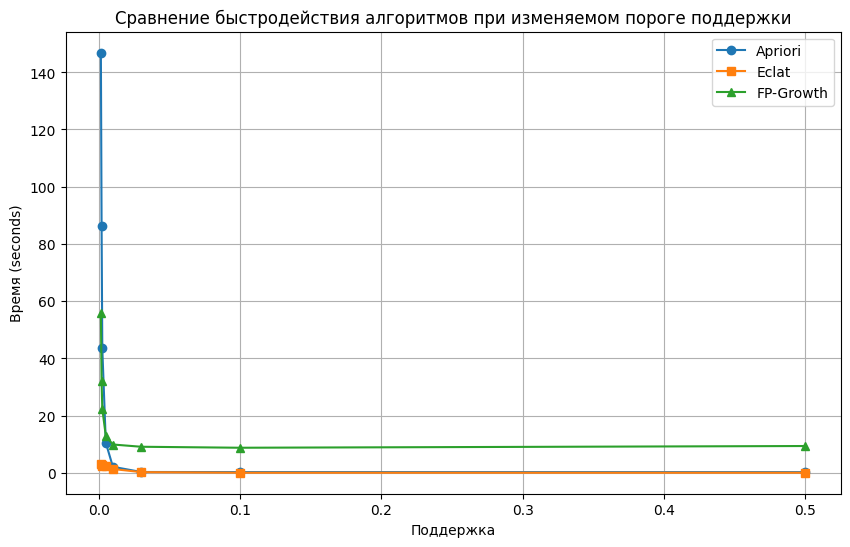

In [ ]:
# Сравнение быстродействия алгоритмов
plt.figure(figsize=(10, 6))
plt.plot(apriori_times['Support'], apriori_times['Time'], label='Apriori', marker='o')
plt.plot(eclat_times['Support'], eclat_times['Time'], label='Eclat', marker='s')
plt.plot(fpgrowth_times['Support'], fpgrowth_times['Time'], label='FP-Growth', marker='^')
plt.xlabel('Поддержка')
plt.ylabel('Время (seconds)')
plt.title('Сравнение быстродействия алгоритмов при изменяемом пороге поддержки')
plt.legend()
plt.grid(True)
plt.show()


### Общее количество частых наборов объектов на фиксированном наборе данных при изменяемом пороге поддержки

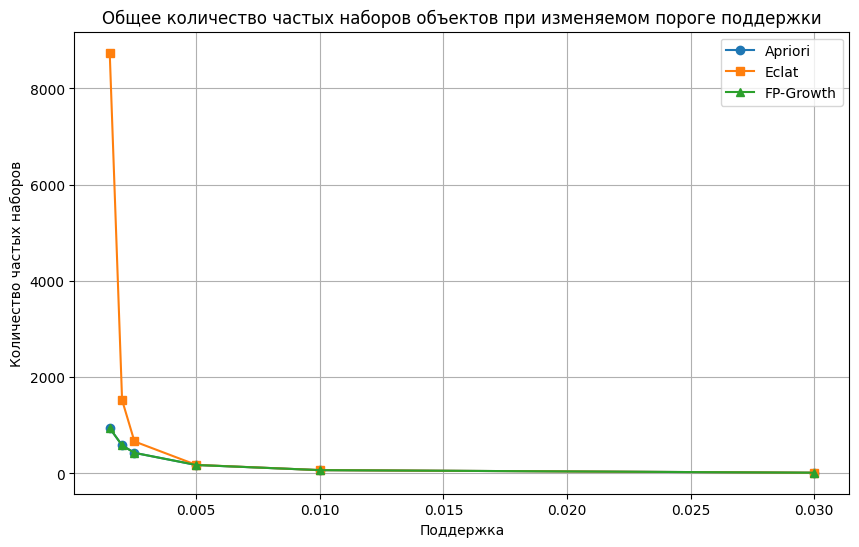

In [ ]:
# Подсчет количества частых наборов для каждого алгоритма и уровня поддержки
apriori_counts = apriori_results.groupby('Support').size().reset_index(name='Counts')
eclat_counts = eclat_results.groupby('Support').size().reset_index(name='Counts')
fpgrowth_counts = fpgrowth_results.groupby('Support').size().reset_index(name='Counts')

# Визуализация общего количества частых наборов объектов
plt.figure(figsize=(10, 6))
plt.plot(apriori_counts['Support'], apriori_counts['Counts'], label='Apriori', marker='o')
plt.plot(eclat_counts['Support'], eclat_counts['Counts'], label='Eclat', marker='s')
plt.plot(fpgrowth_counts['Support'], fpgrowth_counts['Counts'], label='FP-Growth', marker='^')
plt.xlabel('Поддержка')
plt.ylabel('Количество частых наборов')
plt.title('Общее количество частых наборов объектов при изменяемом пороге поддержки')
plt.legend()
plt.grid(True)
plt.show()


### Максимальная длина частого набора объектов на фиксированном наборе данных при изменяемом пороге поддержки

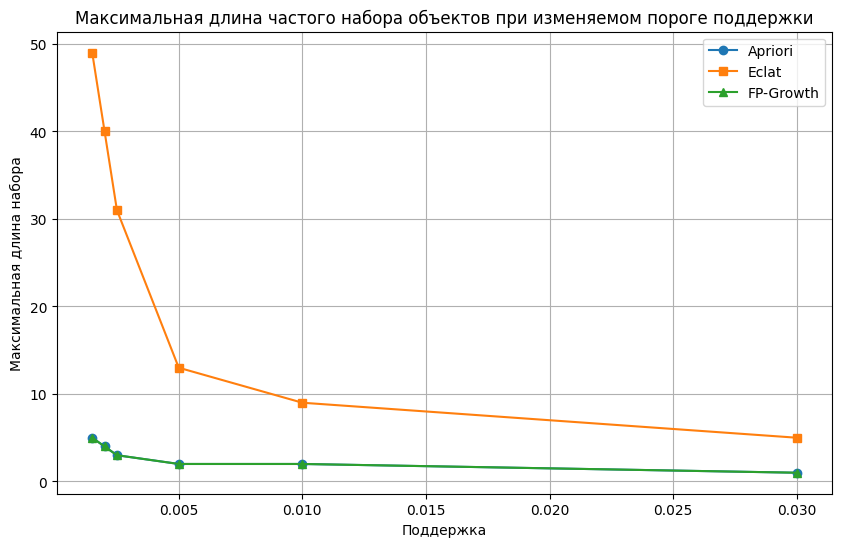

In [ ]:
import matplotlib.pyplot as plt

# Подсчет максимальной длины частого набора для каждого алгоритма и уровня поддержки
apriori_max_len = apriori_results.groupby('Support')['itemsets'].apply(lambda x: x.apply(len).max()).reset_index(name='Max Length')
eclat_max_len = eclat_results.groupby('Support')['itemsets'].apply(lambda x: x.apply(len).max()).reset_index(name='Max Length')
fpgrowth_max_len = fpgrowth_results.groupby('Support')['itemsets'].apply(lambda x: x.apply(len).max()).reset_index(name='Max Length')

# Визуализация максимальной длины частого набора объектов
plt.figure(figsize=(10, 6))
plt.plot(apriori_max_len['Support'], apriori_max_len['Max Length'], label='Apriori', marker='o')
plt.plot(eclat_max_len['Support'], eclat_max_len['Max Length'], label='Eclat', marker='s')
plt.plot(fpgrowth_max_len['Support'], fpgrowth_max_len['Max Length'], label='FP-Growth', marker='^')
plt.xlabel('Поддержка')
plt.ylabel('Максимальная длина набора')
plt.title('Максимальная длина частого набора объектов при изменяемом пороге поддержки')
plt.legend()
plt.grid(True)
plt.show()


### Количество частых наборов объектов различной длины на фиксированном наборе данных при изменяемом пороге поддержки

<ipython-input-65-4c33cf87c259>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apriori_lengths = apriori_results.groupby('Support').apply(count_itemset_lengths).unstack(fill_value=0)
<ipython-input-65-4c33cf87c259>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eclat_lengths = eclat_results.groupby('Support').apply(count_itemset_lengths).unstack(fill_value=0)
<ipython-input-65-4c33cf87c259>:25: Deprec

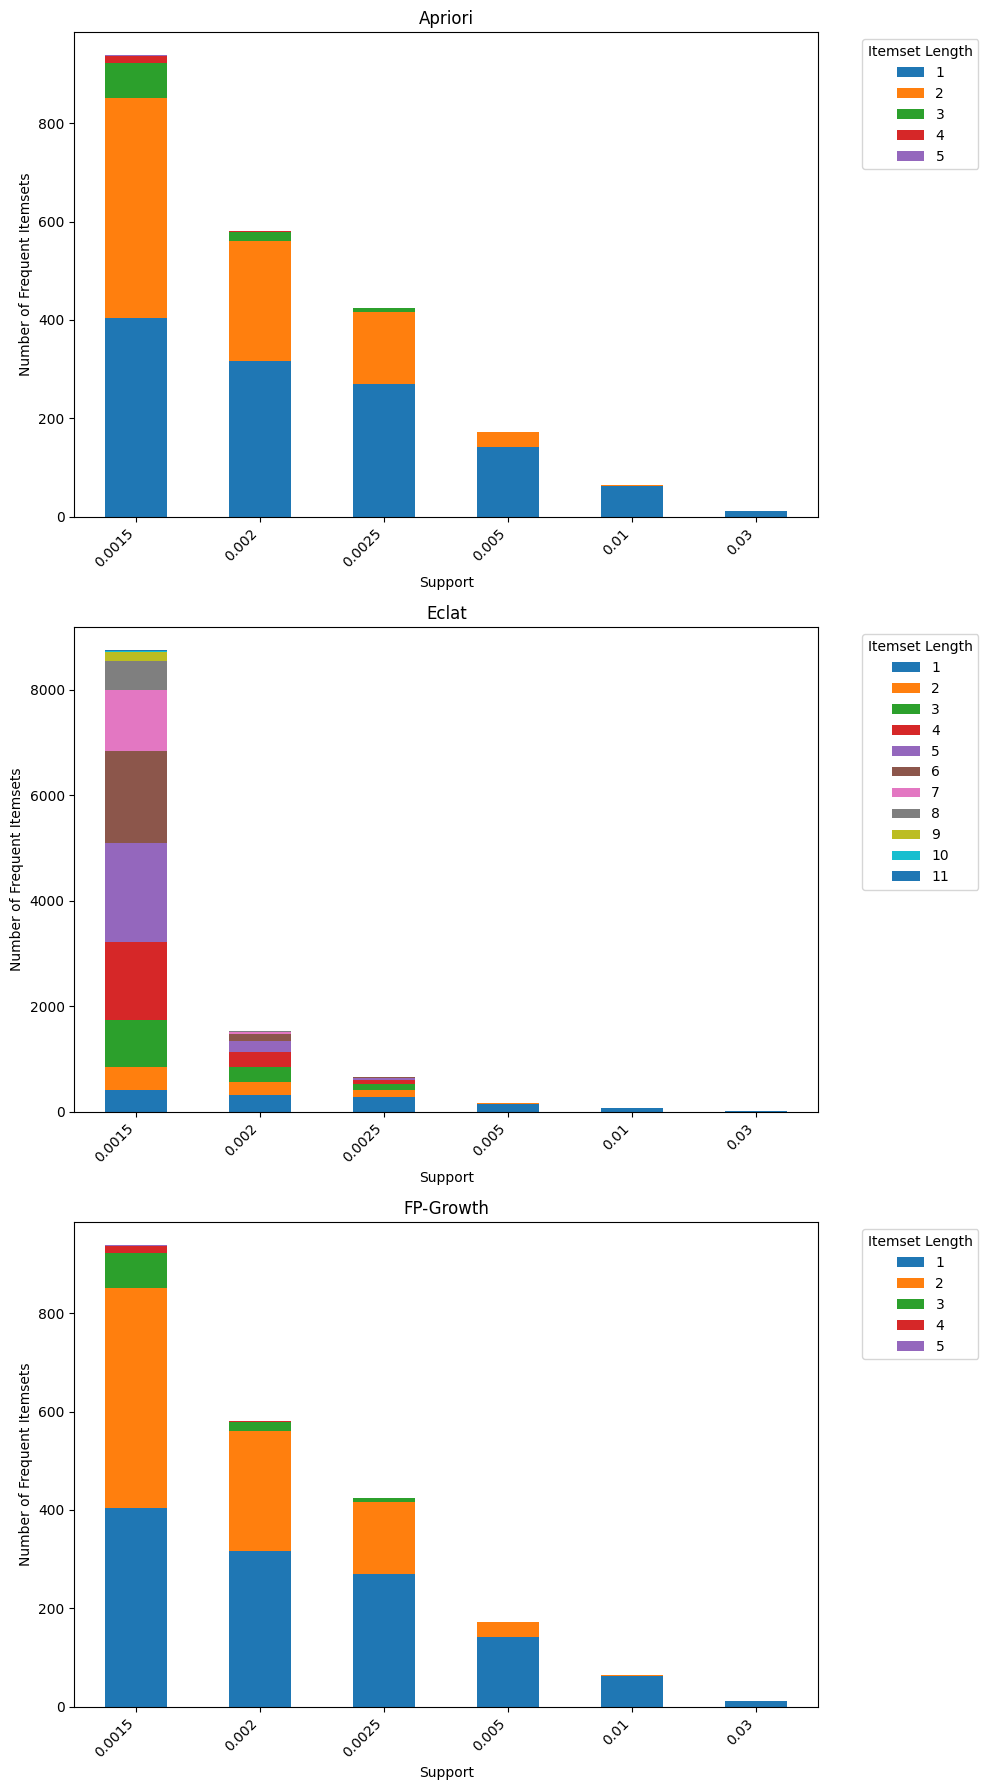

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Преобразование frozenset и списка к единому формату
def normalize_itemsets(itemsets):
    return itemsets.apply(lambda x: eval(x) if isinstance(x, str) else x)

# Загрузка данных из файлов CSV
apriori_results = pd.read_csv('apriori_results.csv')
eclat_results = pd.read_csv('eclat_results.csv')
fpgrowth_results = pd.read_csv('fpgrowth_results.csv')

# Приведение данных к единому формату
apriori_results['itemsets'] = normalize_itemsets(apriori_results['itemsets'])
eclat_results['itemsets'] = normalize_itemsets(eclat_results['itemsets'])
fpgrowth_results['itemsets'] = normalize_itemsets(fpgrowth_results['itemsets'])

# Подсчет количества частых наборов различной длины для каждого алгоритма и уровня поддержки
def count_itemset_lengths(results):
    lengths = results['itemsets'].apply(len)
    return lengths.value_counts().sort_index()

apriori_lengths = apriori_results.groupby('Support').apply(count_itemset_lengths).unstack(fill_value=0)
eclat_lengths = eclat_results.groupby('Support').apply(count_itemset_lengths).unstack(fill_value=0)
fpgrowth_lengths = fpgrowth_results.groupby('Support').apply(count_itemset_lengths).unstack(fill_value=0)

# Визуализация количества частых наборов различной длины
fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=False)

apriori_lengths.plot(kind='bar', stacked=True, ax=axes[0], title='Apriori')
eclat_lengths.plot(kind='bar', stacked=True, ax=axes[1], title='Eclat')
fpgrowth_lengths.plot(kind='bar', stacked=True, ax=axes[2], title='FP-Growth')

for ax, lengths in zip(axes, [apriori_lengths, eclat_lengths, fpgrowth_lengths]):
    ax.set_xlabel('Support')
    ax.set_ylabel('Number of Frequent Itemsets')
    ax.legend(title='Itemset Length', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticks(range(len(lengths.index)))
    ax.set_xticklabels(lengths.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 4. Выводы

Алгоритм ECLAT, в отличие от Apriori и FP-Growth, работает с вертикальными репрезентациями данных. Это позволяет ECLAT более эффективно работать с большими наборами данных и находить больше частых наборов, особенно при низких порогах поддержки. При этом наборы, найденные через Apriori и FP-Growth совпадают с тем, что было найдено в ECLAT.

ECLAT преобразует данные в вертикальную структуру, где для каждого элемента хранится список транзакций, в которых он встречается. Это позволяет быстрее находить пересечения транзакций для поиска частых наборов. ECLAT использует рекурсивный подход для поиска частых наборов, что увеличивает их количество на малом пороге поддержки, так как меньшее количество транзакций необходимо для выполнения условия, при котором набор считается частым.

На более высоких порогах поддрежки, начиная с 0.05, алгоритмы находят одинаковые наборы. В данной задаче, низкий порог поддержки обусловлен спецификой набора данных.

При этом, алгоритм ECLAT показал высокое быстродействие в сравнении с Apriori и FP-Growth.

# Поиск ассоциативных правил


1. Выполните поиск ассоциативных правил для набора данных из задания по поиску частых наборов. Зафиксируйте значение пороговое значение поддержки (например, 10%), варьируйте пороговое значение достоверности (например, от 70% до 95% с шагом 5%).
  - Получите список результирующих правил в удобочитаемом виде (антецедент==>консеквент).
  - Отфильтруйте правила, в которых антецедент и консеквент суммарно включают в себя не более семи объектов.
  - Проанализируйте и изложите содержательный смысл полученного результата.
2. Выполните визуализацию полученных результатов в виде следующих диаграмм:
  - сравнение быстродействия поиска правил на фиксированном наборе данных при изменяемом пороге достоверности;
  - общее количество найденных правил на фиксированном наборе данных при изменяемом пороге достоверности;
  - максимальное количество объектов в правиле на фиксированном наборе данных при изменяемом пороге достоверности;
  - количество правил, в которых антецедент и консеквент суммарно включают в себя не более семи объектов, на фиксированном наборе данных при изменяемом пороге достоверности.
3. Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  
  - формулировка задания;
  - гиперссылка на каталог репозитория с исходными текстами, набором данных и др. сопутствующими материалами;
  - рисунки с результатами визуализации;
  - пояснения, раскрывающие смысл полученных результатов.

## 1. Поиск ассоциативных правил.
Пороговое значение поддержки: 0.15%. Пороговое значение достоверности варьируется от 50% до 90% с шагом в 5%.

Импорт дополнительных библиотек и загрузка данных из прошлой работы.

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import association_rules

# Загрузка данных
fpgrowth_results = pd.read_csv('fpgrowth_results.csv')
publishers_df = pd.read_csv('publishers.csv')

# Преобразование столбца itemsets
fpgrowth_results['itemsets'] = fpgrowth_results['itemsets'].apply(eval)


### Определение параметров, подготовка загруженных данных

In [ ]:
support_thresholds = [0.0015, 0.002, 0.0025, 0.005, 0.01, 0.03, 0.1, 0.5]
min_support = 0.0015

In [ ]:
# Фильтрация частых наборов
frequent_itemsets = fpgrowth_results[fpgrowth_results['Support'] == min_support][['itemsets', 'support']]

In [ ]:
frequent_itemsets.head()

,itemsets,support
0,(0),0.015291
1,(576),0.004258
2,(33),0.048093
3,(281),0.007071
4,(321),0.010515


In [ ]:
# Загрузка словаря для конвертации
publisher_id_to_name = dict(zip(publishers_df['Publisher_ID'], publishers_df['Publisher']))

# Функция для конвертации идентификаторов в имена
def convert_ids_to_names(itemset):
    return [publisher_id_to_name.get(item, item) for item in itemset]


### Генерация правил ассоциаций и фильтрация

In [ ]:
def generate_association_rules(frequent_itemsets, confidence_range):
    rules_list = []
    for min_confidence in confidence_range:
        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence / 100.0)
        rules_list.append(rules)

    # Объединение всех найденных правил
    all_rules = pd.concat(rules_list).drop_duplicates().reset_index(drop=True)

    return all_rules

In [ ]:
confidence_range = range(70, 95, 5)
all_rules = generate_association_rules(frequent_itemsets, confidence_range)

In [ ]:
all_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,"(0, 56)",(55),0.002036,0.040689,0.001851,0.909091,22.342626,1.0,0.001768,10.552425,0.957192,0.045290,0.905235,0.477293
1,"(0, 35)",(55),0.001814,0.040689,0.001629,0.897959,22.069042,1.0,0.001555,9.401251,0.956423,0.039855,0.893631,0.468998
2,(390),(73),0.002518,0.031840,0.001851,0.735294,23.093365,1.0,0.001771,3.657493,0.959112,0.056948,0.726589,0.396717
3,"(35, 67)",(38),0.002036,0.043576,0.001703,0.836364,19.193018,1.0,0.001614,5.844811,0.949832,0.038786,0.828908,0.437723
4,"(0, 98)",(55),0.002555,0.040689,0.002036,0.797101,19.590273,1.0,0.001932,4.728035,0.951385,0.049416,0.788496,0.423573


Анализ полученных результатов:
- antecedent support: доля транзакций, содержащих набор антцендентов, от общего числа транзакций;
- consequent support: доля транзакций, содержащих консеквент, от общего числа транзакций (идентификатор 55 присутствует в 4% от всех транзакций);
- support: доля транзакций, содержащих оба набора;
- confidence: достоверность правила, вероятность того, что консеквент присутствует в транзакции, что там уже есть анцеденты;
- representativity: показывает, насколько часто встречаются комбинации антецедент и консеквент в данной выборке по сравнению с их встречаемостью в случайных данных;
- lift: подъем правила, показывает как увеличивается вероятность присутствия консеквента при наличии антцедента по сравнению с его общей вероятностью;
- leverage: разница между наблюдаемой и ожидаемой частотой, если части правила независимы, чем больше это значение, тем сильнее корреляция;
- conviction: мера частого предсказания антецедентов отсутствия консеквента;
- zhangs_metric: метрика интенсивности связи;
- jaccard: отношение пересечения к объединению множеств антецедентов и консеквентов;
- kulczynski: ассоциация, показывающая баланс между антецедентом и консеквентом.


In [ ]:
def convert_and_filter_rules(all_rules, publisher_id_to_name, min_objects=4, max_objects=7):
    # Конвертация идентификаторов в имена
    all_rules['antecedents'] = all_rules['antecedents'].apply(lambda x: convert_ids_to_names(list(x)))
    all_rules['consequents'] = all_rules['consequents'].apply(lambda x: convert_ids_to_names(list(x)))

    # Фильтрация правил
    filtered_rules = all_rules[
        (all_rules['antecedents'].apply(len) + all_rules['consequents'].apply(len) >= min_objects) &
        (all_rules['antecedents'].apply(len) + all_rules['consequents'].apply(len) <= max_objects)
    ]

    # Преобразование правил в строковый формат
    filtered_rules['rule'] = filtered_rules['antecedents'].apply(lambda x: ', '.join(map(str, list(x)))) + ' ==> ' + filtered_rules['consequents'].apply(lambda x: ', '.join(map(str, list(x))))

    return filtered_rules


In [ ]:
# Получить правила,в которых антецедент и консеквент суммарно включают в себя не менее 3-х и не более 5-ти объектов
filtered_rules = convert_and_filter_rules(all_rules, publisher_id_to_name, min_objects=4, max_objects=7)

<ipython-input-82-bc80e24b9789>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rules['rule'] = filtered_rules['antecedents'].apply(lambda x: ', '.join(map(str, list(x)))) + ' ==> ' + filtered_rules['consequents'].apply(lambda x: ', '.join(map(str, list(x))))


In [ ]:
filtered_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,rule
12,"[Oxford University Press, Signet Book, Dover P...",[Penguin Books],0.001666,0.040689,0.001629,0.977778,24.030735,1.0,0.001561,43.169011,0.959986,0.040000,0.976835,0.508907,"Oxford University Press, Signet Book, Dover Pu..."
13,"[Oxford University Press, Signet Book, Penguin...",[Dover Publications],0.001851,0.012292,0.001629,0.880000,71.592771,1.0,0.001606,8.230902,0.987861,0.130178,0.878507,0.506265,"Oxford University Press, Signet Book, Penguin ..."
14,"[Signet Book, Dover Publications, Penguin Books]",[Oxford University Press],0.002036,0.015291,0.001629,0.800000,52.319613,1.0,0.001598,4.923547,0.982888,0.103774,0.796894,0.453269,"Signet Book, Dover Publications, Penguin Books..."
15,"[Oxford University Press, Signet Book]","[Dover Publications, Penguin Books]",0.002036,0.005368,0.001629,0.800000,149.020690,1.0,0.001618,4.973158,0.995316,0.282051,0.798921,0.551724,"Oxford University Press, Signet Book ==> Dover..."
18,"[Oxford University Press, Penguin Books Ltd, D...",[Penguin Books],0.001740,0.040689,0.001629,0.936170,23.008151,1.0,0.001558,15.029211,0.958205,0.039927,0.933463,0.488103,"Oxford University Press, Penguin Books Ltd, Do..."


In [ ]:
filtered_rules.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, 12 to 123
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         67 non-null     object 
 1   consequents         67 non-null     object 
 2   antecedent support  67 non-null     float64
 3   consequent support  67 non-null     float64
 4   support             67 non-null     float64
 5   confidence          67 non-null     float64
 6   lift                67 non-null     float64
 7   representativity    67 non-null     float64
 8   leverage            67 non-null     float64
 9   conviction          67 non-null     float64
 10  zhangs_metric       67 non-null     float64
 11  jaccard             67 non-null     float64
 12  certainty           67 non-null     float64
 13  kulczynski          67 non-null     float64
 14  rule                67 non-null     object 
dtypes: float64(12), object(3)
memory usage: 8.4+ KB


In [ ]:
def print_and_save_rules(filtered_rules, filename='filtered_rules.csv'):
    print("Результирующие правила:")
    print(filtered_rules[['rule', 'support', 'confidence']])

    filtered_rules[['rule', 'support', 'confidence']].to_csv(filename, index=False)

    for index, row in filtered_rules.iterrows():
        print(f"Правило: {row['rule']}")
        print(f"  - Поддержка: {row['support']}")
        print(f"  - Достоверность: {row['confidence']}")
        print()

print_and_save_rules(filtered_rules)

Результирующие правила:
                                                  rule   support  confidence
12   Oxford University Press, Signet Book, Dover Pu...  0.001629    0.977778
13   Oxford University Press, Signet Book, Penguin ...  0.001629    0.880000
14   Signet Book, Dover Publications, Penguin Books...  0.001629    0.800000
15   Oxford University Press, Signet Book ==> Dover...  0.001629    0.800000
18   Oxford University Press, Penguin Books Ltd, Do...  0.001629    0.936170
..                                                 ...       ...         ...
119  Penguin Books Ltd, NTC/Contemporary Publishing...  0.001555    0.777778
120  Dover Publications, Penguin Books Ltd, NTC/Con...  0.001555    0.954545
121  Dover Publications, Penguin Books Ltd, Penguin...  0.001555    0.763636
122  Penguin Books Ltd, NTC/Contemporary Publishing...  0.001555    0.857143
123  Penguin Books Ltd, NTC/Contemporary Publishing...  0.001555    0.777778

[67 rows x 3 columns]
Правило: Oxford University Pr

## 2. Визуализация полученных результатов

In [ ]:
# Фильтрация частых наборов
fpgrowth_results = pd.read_csv('fpgrowth_results.csv')
publishers_df = pd.read_csv('publishers.csv')
fpgrowth_results['itemsets'] = fpgrowth_results['itemsets'].apply(eval)
min_support = 0.0015
frequent_itemsets = fpgrowth_results[fpgrowth_results['Support'] == min_support][['itemsets', 'support']]

### 1. Сравнение быстродействия поиска правил на фиксированном наборе данных при изменяемом пороге достоверности.

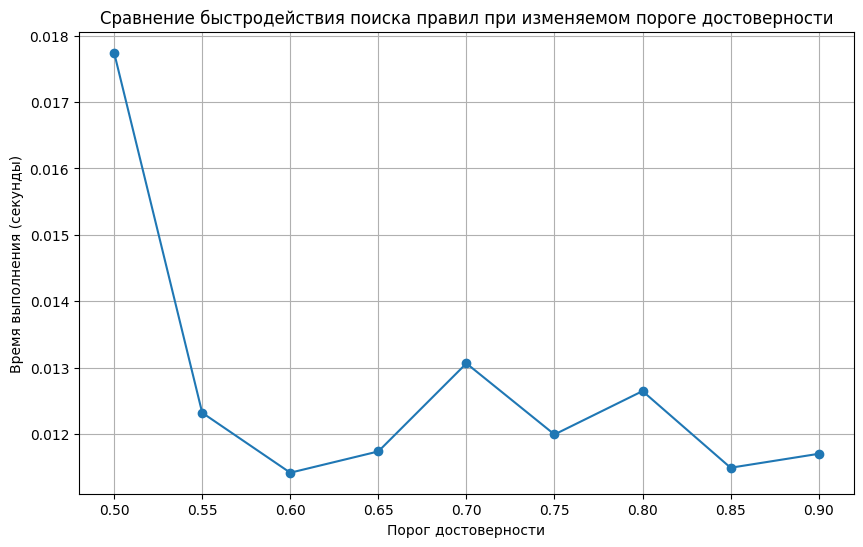

In [ ]:
def generate_association_rules_with_times(frequent_itemsets, confidence_range):
    times_dict = {conf: [] for conf in confidence_range}

    for _ in range(100):
        for min_confidence in confidence_range:
            start_time = time.time()
            _ = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence / 100.0)
            end_time = time.time()
            times_dict[min_confidence].append(end_time - start_time)

    avg_times = {conf: sum(times_dict[conf]) / len(times_dict[conf]) for conf in confidence_range}
    return avg_times

# Вызов функции генерации правил с измерением времени
confidence_range = range(50, 95, 5)
avg_times = generate_association_rules_with_times(frequent_itemsets, confidence_range)
# Извлечение времени выполнения для каждого порога достоверности
confidence_levels = [min_confidence / 100.0 for min_confidence in confidence_range]
avg_times_list = [avg_times[conf] for conf in confidence_range]

# Построение диаграммы сравнения быстродействия
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels, avg_times_list, marker='o')
plt.title('Сравнение быстродействия поиска правил при изменяемом пороге достоверности')
plt.xlabel('Порог достоверности')
plt.ylabel('Время выполнения (секунды)')
plt.grid(True)
plt.show()


Время выполнения алгоритма уменьшается с увеличением порога достоверности. Алгоритм работает медленнее при низких порогах достоверности. После достижения порога достоверности около 0.55, время выполнения становится стабильным.

### 2. Общее количество найденных правил на фиксированном наборе данных при изменяемом пороге достоверности

In [ ]:
def generate_association_rules_count(frequent_itemsets, confidence_range):
    rules_count = {}
    for min_confidence in confidence_range:
        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence / 100.0)
        rules_count[min_confidence] = len(rules)

    return rules_count

# Вызов функции генерации правил с подсчетом количества
confidence_range = range(50, 95, 5)
rules_count = generate_association_rules_count(frequent_itemsets, confidence_range)

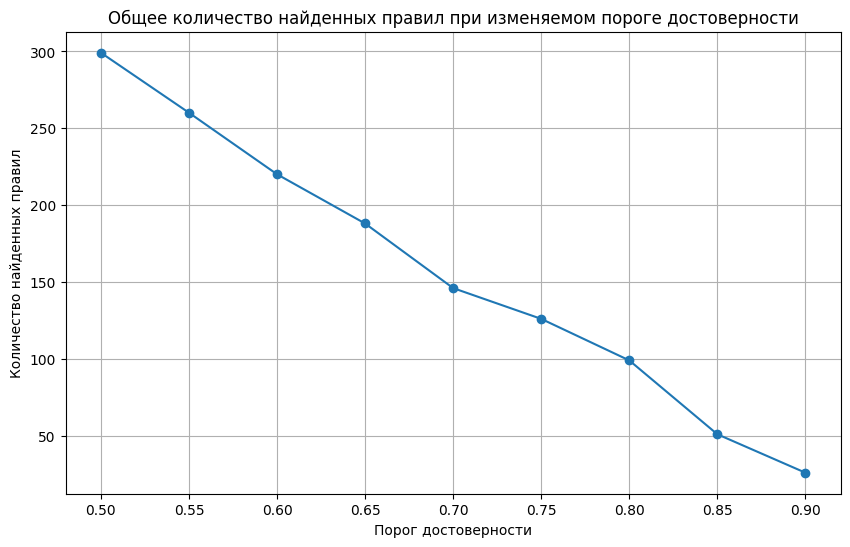

In [ ]:
confidence_levels = [min_confidence / 100.0 for min_confidence in confidence_range]
rules_count_list = [rules_count[conf] for conf in confidence_range]

plt.figure(figsize=(10, 6))
plt.plot(confidence_levels, rules_count_list, marker='o')
plt.title('Общее количество найденных правил при изменяемом пороге достоверности')
plt.xlabel('Порог достоверности')
plt.ylabel('Количество найденных правил')
plt.grid(True)
plt.show()

Количество найденных правил уменьшается с увеличением порога достоверности.

По мере увеличения порога достоверности количество найденных правил уменьшается.

 Увеличение порога достоверности ведет к более строгим условиям, и меньшее количество комбинаций антецедентов и консеквентов удовлетворяют этим условиям.

### 3. Максимальное количество объектов в правиле на фиксированном наборе данных при изменяемом пороге достоверности

In [ ]:
def generate_association_rules_max_items(frequent_itemsets, confidence_range):
    max_items_dict = {}
    for min_confidence in confidence_range:
        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence / 100.0)
        max_items = rules['antecedents'].apply(len).max() + rules['consequents'].apply(len).max()
        max_items_dict[min_confidence] = max_items

    return max_items_dict

# Вызов функции генерации правил с подсчетом максимального количества объектов в правиле
confidence_range = range(50, 95, 5)
max_items_dict = generate_association_rules_max_items(frequent_itemsets, confidence_range)

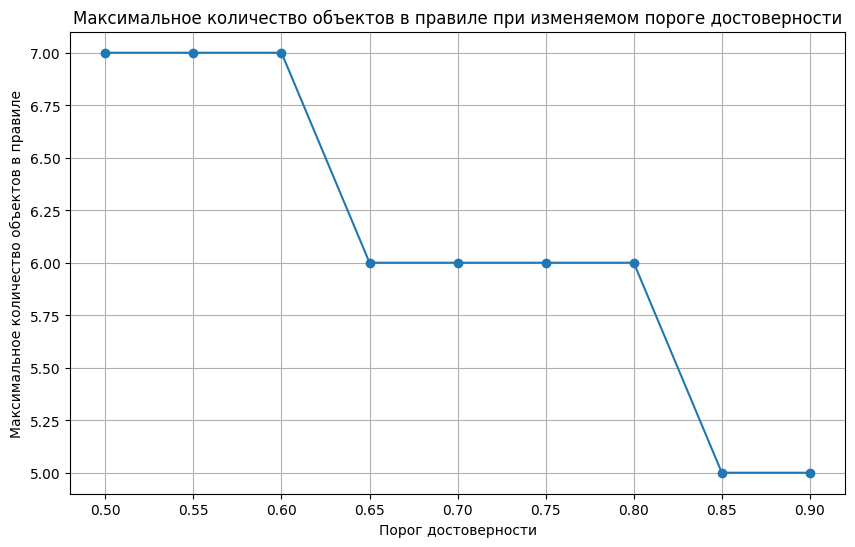

In [ ]:
confidence_levels = [min_confidence / 100.0 for min_confidence in confidence_range]
max_items_list = [max_items_dict[conf] for conf in confidence_range]

plt.figure(figsize=(10, 6))
plt.plot(confidence_levels, max_items_list, marker='o')
plt.title('Максимальное количество объектов в правиле при изменяемом пороге достоверности')
plt.xlabel('Порог достоверности')
plt.ylabel('Максимальное количество объектов в правиле')
plt.grid(True)
plt.show()

: Максимальное количество объектов в правиле уменьшается с увеличением порога достоверности. Увеличение порога достоверности ведет к уменьшению максимального количества объектов в правилах.

### 4. Количество правил, в которых антецедент и консеквент суммарно включают в себя не более семи объектов, на фиксированном наборе данных при изменяемом пороге достоверности.

In [ ]:
def generate_association_rules_filtered_count(frequent_itemsets, confidence_range, min_objects, max_objects):
    rules_filtered_count = {}
    for min_confidence in confidence_range:
        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence / 100.0)
        filtered_rules = rules[
            (rules['antecedents'].apply(len) + rules['consequents'].apply(len) >= min_objects) &
            (rules['antecedents'].apply(len) + rules['consequents'].apply(len) <= max_objects)
        ]
        rules_filtered_count[min_confidence] = len(filtered_rules)

    return rules_filtered_count

confidence_range = range(50, 95, 5)
filtered_rules_count1 = generate_association_rules_filtered_count(frequent_itemsets, confidence_range, min_objects=3, max_objects=7)
filtered_rules_count2 = generate_association_rules_filtered_count(frequent_itemsets, confidence_range, min_objects=2, max_objects=7)
filtered_rules_count3 = generate_association_rules_filtered_count(frequent_itemsets, confidence_range, min_objects=4, max_objects=7)

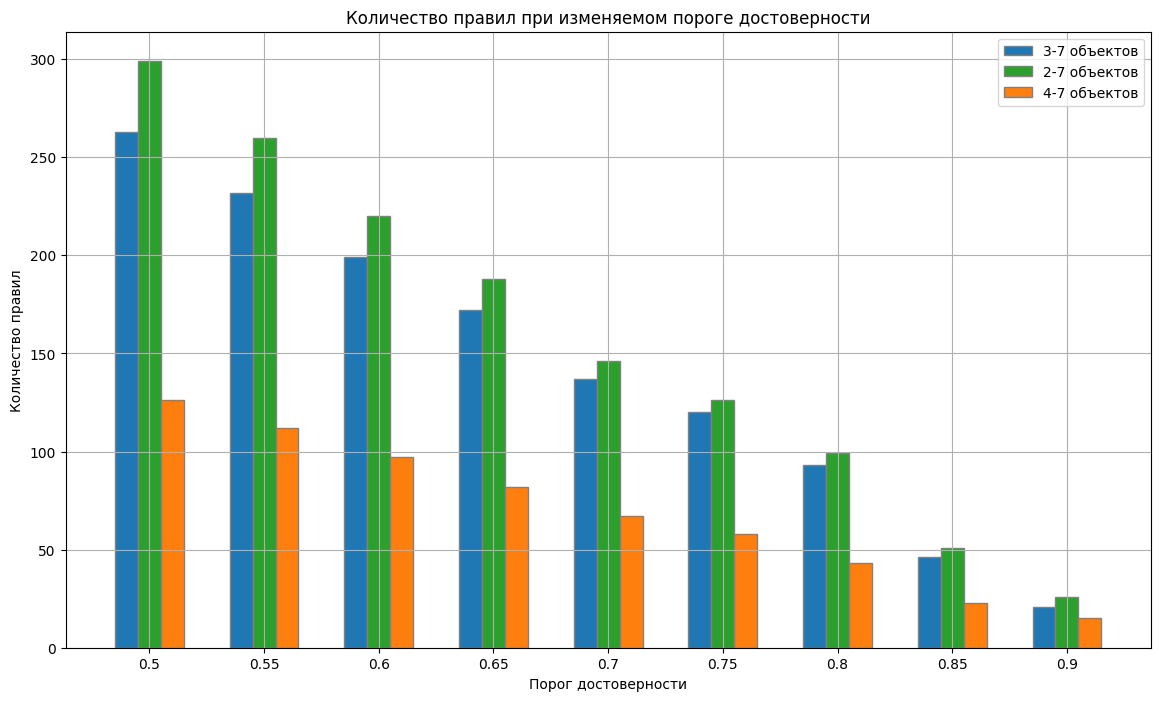

In [ ]:
# Извлечение количества фильтрованных правил для каждого порога достоверности
confidence_levels = [min_confidence / 100.0 for min_confidence in confidence_range]
filtered_rules_count_list1 = [filtered_rules_count1[conf] for conf in confidence_range]
filtered_rules_count_list2 = [filtered_rules_count2[conf] for conf in confidence_range]
filtered_rules_count_list3 = [filtered_rules_count3[conf] for conf in confidence_range]

# Построение столбчатой диаграммы количества фильтрованных правил
bar_width = 0.2
r1 = np.arange(len(confidence_levels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

colors = ['#1f77b4', '#2ca02c', '#ff7f0e']
plt.figure(figsize=(14, 8))
plt.bar(r1, filtered_rules_count_list1, color=colors[0], width=bar_width, edgecolor='grey', label='3-7 объектов')
plt.bar(r2, filtered_rules_count_list2, color=colors[1], width=bar_width, edgecolor='grey', label='2-7 объектов')
plt.bar(r3, filtered_rules_count_list3, color=colors[2], width=bar_width, edgecolor='grey', label='4-7 объектов')

plt.xlabel('Порог достоверности')
plt.ylabel('Количество правил')
plt.title('Количество правил при изменяемом пороге достоверности')
plt.xticks([r + bar_width for r in range(len(confidence_levels))], confidence_levels)
plt.legend()
plt.grid(True)

Наблюдается снижение количества правил с увеличением порога достоверности.  равила с 2-7 объектами имеют большее количество по сравнению с диапазонами 3-7 и 4-7 объектов.